<h1><center>Save information from LAS files into CSV files </center></h1>

This code is designed to loop over a directory containing **LAS** files for a particular well, and extract curves of interest. Formation to depth will be interpolated using the specifed formation to depth data provided for each well. Curves contained in multiple LAS files will be concatanated 

In [1]:
# Import relevant libraries
import glob
import pandas as pd
import numpy as np
import lasio
import matplotlib.pyplot as plt

In [2]:
# Specify well of interest
well = "Laub"
directory = rf"C:\Users\ibibe\Desktop\Projects\Geophysics\Well Logs\Kinney\{well}\*.las" # Base directory with LAS files

In [3]:
def file_concat(directory):
    ''' 
    Summary: This code concatnates all LAS files into a single python object for looping
    
    Inputs: Directory containing specified LAS files
    Outputs: Object containing directory of each LAS file
    
    '''
    files = []
    
    for filepath in glob.iglob(directory):
        files.append(filepath)
        
    return files

In [4]:
                # Example
files = file_concat(directory)
files

['C:\\Users\\ibibe\\Desktop\\Projects\\Geophysics\\Well Logs\\Kinney\\Laub\\1044966711.las',
 'C:\\Users\\ibibe\\Desktop\\Projects\\Geophysics\\Well Logs\\Kinney\\Laub\\1044966712.las']

In [5]:
def curve_extractor(curves, all_curves):
    ''' 
    Summary: This code loads in las files and extracts the specified well curves 
    
    Inputs: List of specific log data headers to be read (curve mnemonic)
    all_curves: Dataframe containing the all log data
    '''
    
    df_curves = pd.DataFrame(columns=curves)
    
    for curve in curves:
        try:
            df_curves[curve] = all_curves[curve]
        except:
            df_curves[curve] = 999
            
    return df_curves  

In [6]:
                # Example
las = lasio.read(files[1]) 
curves = ['DEPT','GR','CILD','RHOB','NPLS','PE']
lasdf= pd.DataFrame(las.data,columns=list(las.curvesdict.keys()))
df_curves = curve_extractor(curves,lasdf)
df_curves.dropna()

,DEPT,GR,CILD,RHOB,NPLS,PE
56,254.2,57.53,79.57,2.19,45.31,7.48
57,254.7,56.48,79.74,2.21,43.77,7.48
58,255.2,56.31,80.19,2.18,42.45,7.56
59,255.7,58.14,81.88,2.12,42.56,7.60
60,256.2,61.73,84.04,2.06,43.44,7.44
...,...,...,...,...,...,...
2184,1318.2,154.87,70.66,2.48,16.19,5.75
2185,1318.7,167.70,62.43,2.50,16.29,5.56
2186,1319.2,173.03,52.71,2.53,16.35,4.70
2187,1319.7,171.10,41.55,2.53,16.33,4.01


In [7]:
def interpolate_depth(formation_name,depth_to_top,interval,max_depth):
    '''
    Summary: Function takes in a list of formation names and depths and uses block interpolation to construct an array
    of formation depths for each formation
    
    Inputs:
    Formation_name = list of formation names
    depth_to_top = depth at which the formation begins
    interval = depth interval
    max_depth = max_depth for LAS file
    '''
    
    df = pd.DataFrame(columns=['DEPT','Formation'])
    
    # Append the very last formation name and max depth to list to extend to max depth
    formation_name.append(formation_name[-1])
    depth_to_top.append(max_depth)
    
    # Append a zero depth to account for formations not starting at 0. We assume those depths have an unknown formation
    formation_name.insert(0,'Unknown')
    depth_to_top.insert(0,0)
           
    for i in range(0,len(formation_name)-1):      
        depths = np.arange(depth_to_top[i],depth_to_top[i+1],interval)
        dict_list = {'DEPT': depths, "Formation": formation_name[i]}
        
        df_new = pd.DataFrame(dict_list)
        df = pd.concat([df,df_new])
        
    df.reset_index(drop=True,inplace=True)
        
    return df

In [8]:
def make_csv(las_files,curves,formation_name,depth_to_top,interval):
    ''' 
    
    Summary: Extract relevant well curves from las files and concatanate into data frame.
    Also includes interpolated well names and depth to formation tops
    
    Inputs:
    las_files = list containing path to las files
    formation_tops = list of strings specifying different formations
    depth_to_top = list of depths 
    interval = 
    curves = Well logs of interest   
    '''
    
    # Create empty dataframe
    df = pd.DataFrame(columns=curves)
    
    for file in range(1): # las_files:#range(1):
        
        # Load in file
        las = lasio.read(las_files[1]) 
        
        lasdf= pd.DataFrame(las.data,columns=list(las.curvesdict.keys()))
        
        df_curves = curve_extractor(curves,lasdf)
        df = pd.concat([df,df_curves])
        

    df.reset_index(drop=True,inplace=True)
        
    # Create Formation depths dataframe
    max_depth = df['DEPT'].max()
    depth_df = interpolate_depth(formation_name,depth_to_top,interval,max_depth)
    
    print(np.argmin(df['DEPT'][0] - depth_df['DEPT']))
    
    # Assign formation names with depth 
    df['Formation'] = df['DEPT'].apply(lambda x: depth_df['Formation'].iloc[np.argmin(np.abs(x-depth_df['DEPT']))] )
    df['Well name'] = las.well['WELL'].value.strip() 
        
    return df   

In [43]:
                        # Final assignment 
    # Well information and formation depths can be obtained at http://www.kgs.ku.edu/Magellan/Qualified/index.html
    # Example well: https://chasm.kgs.ku.edu/ords/qualified.well_page.DisplayWell?f_kid=1043624968
    
                        # Laub
Formation_name= ['Heebner','Lansing','Kansas City','Viola','Simpson sandstone','Granite']
top = [523,658,930,1059,1279,1310]

# Parameters
curves = ['DEPT','GR','CILD','RHOB','NPLS','PE','ILD','SP','DT','CALD']
files = file_concat(directory)
interval = 0.5
Curves = make_csv(files,curves,Formation_name,top,interval)

2726


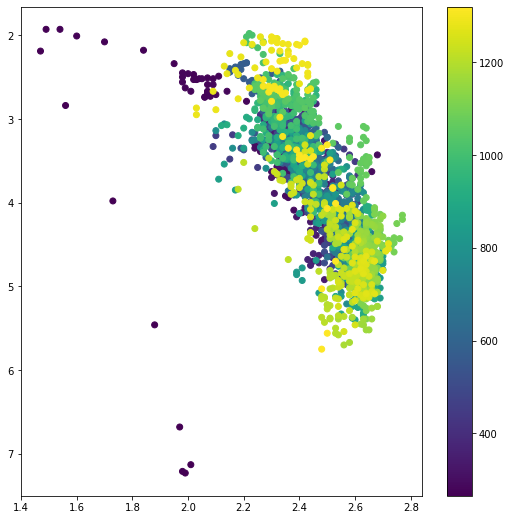

In [46]:
plt.figure(figsize=(9,9))
plt.scatter(Curves.dropna().RHOB,(Curves.dropna().PE),c=Curves.dropna().DEPT)
plt.gca().invert_yaxis()
plt.xlabel('Density ')
plt.ylabel('Photo-absoprtion factor')
cbar = plt.colorbar()
cbar.solids.set_edgecolor("face")
plt.draw()

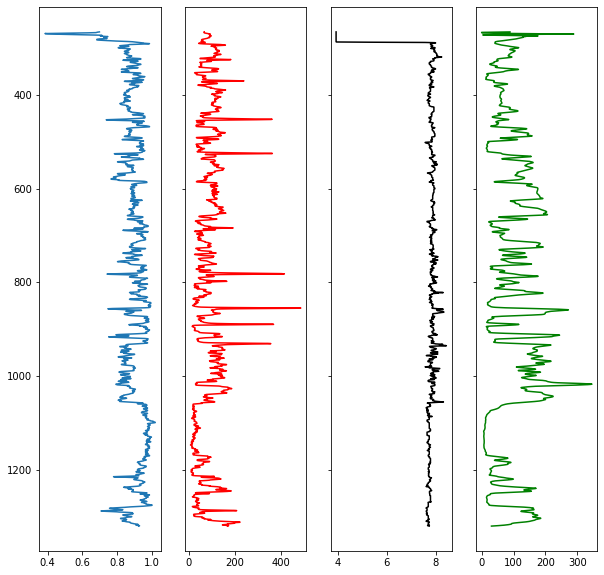

In [26]:
fig, ax = plt.subplots(1, 4,sharey=True,figsize=(10,10))
ax[0].plot(np.log(Curves.dropna().RHOB),Curves.dropna().DEPT)
ax[1].plot(Curves.dropna().GR,Curves.dropna().DEPT,c='r')
ax[2].plot(Curves.dropna().CALD,Curves.dropna().DEPT,c='k')
ax[3].plot(Curves.dropna().CILD,Curves.dropna().DEPT,c='g')
fig.gca().invert_yaxis()

In [ ]:
# Save to file
curve_file = well + "_Kinney_curves.csv"
Curves.to_csv(curve_file,index=False)

In [12]:
list(las.curves)

[CurveItem(mnemonic=DEPT, unit=FEET, value=00 001 00 00, descr=Measured Depth, original_mnemonic=DEPT, data.shape=(2275,)),
 CurveItem(mnemonic=CILD, unit=mMHO, value=07 110 45 00, descr=Deep Induction R Conductivity, original_mnemonic=CILD, data.shape=(2275,)),
 CurveItem(mnemonic=CALN, unit=in, value=45 280 24 00, descr=Compensated Neutron Caliper (Diameter), original_mnemonic=CALN, data.shape=(2275,)),
 CurveItem(mnemonic=CALD, unit=in, value=45 280 13 00, descr=Litho Caliper (Diameter), original_mnemonic=CALD, data.shape=(2275,)),
 CurveItem(mnemonic=DT, unit=us/ft, value=60 520 32 00, descr=Depth Derived Compensated Sonic Delta Time (uS/Foot), original_mnemonic=DT, data.shape=(2275,)),
 CurveItem(mnemonic=GR, unit=gAPI, value=07 310 01 00, descr=Gamma Ray - API Units, original_mnemonic=GR, data.shape=(2275,)),
 CurveItem(mnemonic=ILD, unit=ohm/m, value=07 120 45 00, descr=Phased Deep Induction Resistivity, original_mnemonic=ILD, data.shape=(2275,)),
 CurveItem(mnemonic=ILM, unit=o

In [16]:
Curves.dropna().corr()

,DEPT,GR,CILD,RHOB,NPLS,PE,ILD,SP,DT,CALN
DEPT,1.000000,-0.232695,0.005724,0.317753,-0.524482,0.196736,-0.028023,0.166407,-0.566775,0.107773
GR,-0.232695,1.000000,0.485215,-0.479219,0.604132,-0.425860,-0.057657,0.231887,0.553929,0.049350
CILD,0.005724,0.485215,1.000000,-0.614348,0.650886,-0.732712,-0.109951,0.111754,0.500907,0.034215
RHOB,0.317753,-0.479219,-0.614348,1.000000,-0.793666,0.730822,-0.051411,0.215657,-0.696732,0.366211
NPLS,-0.524482,0.604132,0.650886,-0.793666,1.000000,-0.703996,0.007058,0.030793,0.844669,-0.176906
PE,0.196736,-0.425860,-0.732712,0.730822,-0.703996,1.000000,0.176330,0.202333,-0.625506,0.031945
ILD,-0.028023,-0.057657,-0.109951,-0.051411,0.007058,0.176330,1.000000,0.014457,-0.017187,-0.282857
SP,0.166407,0.231887,0.111754,0.215657,0.030793,0.202333,0.014457,1.000000,0.000512,0.087924
DT,-0.566775,0.553929,0.500907,-0.696732,0.844669,-0.625506,-0.017187,0.000512,1.000000,-0.083658
CALN,0.107773,0.049350,0.034215,0.366211,-0.176906,0.031945,-0.282857,0.087924,-0.083658,1.000000
